# Tweet Clustering with K-Means

Here, we will use the k-means algorithm, an unsupervised clustering algorithm, to cluster the tweets taken from a collection of tweets into different groups. 

The main focus of using K-means is to group the simial data points together and discover the patterns.To acheive this, the algorithm is meant to find defined number of optimal centeroiods(k) in a dataset. A centeroid refers to an aggregated point of common features. The 'means' in the K-means refers to the averaging og the data which is finding the centeroid.

Below is a visualizing .gif of the algorithm execution, which helps you to understand how the algorithm is used in practice.

<img src="Images/kmeans.gif">

Steps:
1. Explore our collection of tweets (corpus)
2. Data Engineer the dataset to get the best perfomance from the K-means algorithm
3. Run the algorithm many times, each time testing with a different number of clusters
4. Use different metrics to visualize our results and find the best number of clusters (ie. Why are a total of X clusters better than a total of Y clusters)
5. Cluster Analysis

Metrics Utilized for Determining the Best Number of K Clusters
- Elbow Method
- Silhouette Score

## Importing Libraries

In [1]:
# Data Structures
import numpy  as np
import pandas as pd
import json

# Corpus Processing
import string
import re
import csv
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from nltk.corpus                      import wordnet as wn
from nltk.stem                        import WordNetLemmatizer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize
from collections                      import Counter

# K-Means
from sklearn import cluster
from sklearn.cluster import KMeans

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.datasets                 import make_blobs
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud
from jupyterthemes                    import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

## Import the .csv file to the Kernel

In here, we use pandas library to import the .csv file as a dataframe, which enables us to do lot of functions using the dataframe object which simplifies the processes. Instead pandas, we can use graphlab create library which is availabe for Anaconda 2 with python 2.7 as it's working environment.

You can find the instructions on how to use graphlab create at, <a>https://turi.com</a>

As many of the words containg may have non UTF-8 characters(generally names of places and such), we'll read the file with the encoding.

In [2]:
tweets_df = pd.read_csv('tweets.csv',names=['id', 'user_id', 'tweet','created_at','hashtags','number_of_hashtags','quoted_status','retweeted_status','favourite_count','favourited','retweet_count','retweeted','possibly_sensitive','withheld_copyright','annotationMethod','maliciousMark','country','city','longitude_latitude'],encoding='utf-8')

## Information about the tweets_df Dataframe

In [3]:
tweets_df.info

<bound method DataFrame.info of                          id    user_id  \
0                        20         12   
1                 857639318   15421499   
2                1219854841   21111883   
3                1351943552   23551474   
4                1403439262   21111883   
...                     ...        ...   
1308463  330399943359594496  778865262   
1308464  330399943380570112  703259586   
1308465  330399943405748224  602332577   
1308466  330399943422513153  259905268   
1308467  330399943456071681  223668163   

                                                     tweet  \
0                                 just setting up my twttr   
1                                             why twitter?   
2        procrastinating in school listening to interes...   
3             i be upp in the gym jus workin on my fitness   
4        @selenagomez DUH. You were in my dream last ni...   
...                                                    ...   
1308463  I can go Detective's

## Describing the tweets_df Dataframe to Get a Basic Idea of the Values

In [4]:
tweets_df.describe()

,id,user_id,number_of_hashtags,quoted_status,retweeted_status,favourite_count,favourited,retweet_count,retweeted,possibly_sensitive,withheld_copyright,annotationMethod,maliciousMark
count,1.308468e+06,1.308468e+06,1.308468e+06,115.0,276386.0,1.308468e+06,1308468.0,1.308468e+06,1308468.0,379639.000000,0.0,1.149553e+06,1.149553e+06
mean,3.299663e+17,4.355787e+08,5.822374e-01,1.0,1.0,1.258311e+01,0.0,3.982593e+02,0.0,0.015286,NaN,5.060541e+00,1.729342e-01
std,4.827833e+15,3.832967e+08,1.145427e+00,0.0,0.0,7.624746e+02,0.0,5.257034e+03,0.0,0.122686,NaN,1.498076e+00,3.880964e-01
min,2.000000e+01,1.200000e+01,0.000000e+00,1.0,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,NaN,1.000000e+00,-1.000000e+00
25%,3.299767e+17,1.235805e+08,0.000000e+00,1.0,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,NaN,5.000000e+00,0.000000e+00
50%,3.300480e+17,3.310329e+08,0.000000e+00,1.0,1.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,NaN,6.000000e+00,0.000000e+00
75%,3.302841e+17,6.021673e+08,1.000000e+00,1.0,1.0,0.000000e+00,0.0,2.000000e+00,0.0,0.000000,NaN,6.000000e+00,0.000000e+00
max,3.303999e+17,1.400487e+09,3.000000e+01,1.0,1.0,2.277610e+05,0.0,4.624150e+05,0.0,1.000000,NaN,6.000000e+00,1.000000e+00


## Identifying the null Values Present in the Dataframe

The seaborn library gives us the functionality of heatmap to get a rough idea on the spread of the values in the dataset. Using it we can identify the null values present in the dataframe.

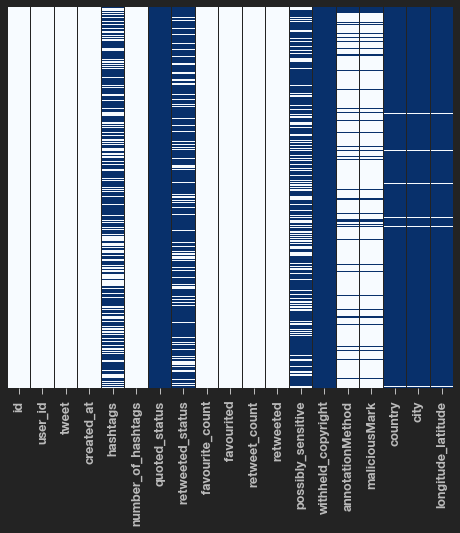

In [5]:
sns.heatmap(tweets_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

Although the id user_id tweet and other few columns don't show having null valus in the heatmap, they may contain null values. If we have null values on tweets column we need to remove them to get optimal results. To identify whether they have null values we can get a summary and identify if they contain null values or not.

In [6]:
tweets_df.isnull().sum()

id                          0
user_id                     0
tweet                       0
created_at                  0
hashtags               877606
number_of_hashtags          0
quoted_status         1308353
retweeted_status      1032082
favourite_count             0
favourited                  0
retweet_count               0
retweeted                   0
possibly_sensitive     928829
withheld_copyright    1308468
annotationMethod       158915
maliciousMark          158915
country               1288847
city                  1288673
longitude_latitude    1288673
dtype: int64

There are no null values present in the dataframe.

## Exploratory Analysis of the tweets_df Dataframe

First make a new column named 'length' in the dataframe and use `.apply()` function in dataframe to apply `len` function which shows the length of each tweet in the dataframe.

In [7]:
tweets_df['length'] = tweets_df['tweet'].apply(len)

Let's plot a histogram to identify the distribution of tweets in accordacne with their length

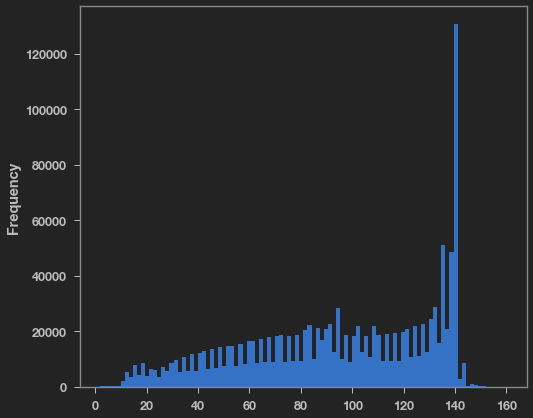

In [8]:
tweets_df['length'].plot(bins=100, kind='hist')

Some crude analysis on tweet lengths

In [9]:
tweets_length=tweets_df.copy()
tweets_length=tweets_length['length']
tweets_length=tweets_length.to_frame()
tweets_length.describe()

,length
count,1.308468e+06
mean,9.481694e+01
std,3.670923e+01
min,2.000000e+00
25%,6.700000e+01
50%,9.800000e+01
75%,1.300000e+02
max,1.600000e+02


Some tweet examples according to the length descriptions we obtained from `tweets_length.describe()`

In [10]:
#shortest tweet
tweets_df[tweets_df['length']==2]['tweet'].iloc[0]

'ff'

In [11]:
#longest tweet
tweets_df[tweets_df['length']==160]['tweet'].iloc[0]

"The fact that I woke up with a horrible headache this morning&lt;&lt;&lt;&lt;&lt;&lt;&lt; I mean I didn't even drink last night all I did was go to sleep geeezz"

In [12]:
#an average lengthed tweet
tweets_df[tweets_df['length']==93]['tweet'].iloc[0]

'Having a fabulous dinner with the girls. Love Shoreditch House as much as I love the company.'

## Cleaning Data Set

## Remove the Duplicate tweets in the Dataset

We can use a brute froce approach or the pandas dataframe based approach to remove the duplicate words. As it is easier to use the dataframe object itself for diligence, the duplicates were removed using the `drop_duplicate()` function.

In [13]:
data=tweets_df.copy()
data = data['tweet']
data=data.to_frame()
data.drop_duplicates(subset='tweet', keep=False, inplace=True)
data.head(6)

,tweet
0,just setting up my twttr
1,why twitter?
2,procrastinating in school listening to interes...
3,i be upp in the gym jus workin on my fitness
4,@selenagomez DUH. You were in my dream last ni...
5,"Driving along on a plastic dream, heart beats ..."


In [14]:
data.duplicated(['tweet']).sum()

0

The `data.duplicated(['tweet']).sum()` shows that there are no duplicates in the dataset. Hence, we can conclude that the duplicates are removed.

## Removing Stop Words, Puncuations and Biased Words and Ouliers from the Dataset

First we make the `tweet` column into a list and take it as our `corpus` for processing. After that URLs, @mentions, unwanted unicode characters, stop words and biased words like words which have less than two letters or more than 21 letters are removed.

After that we need to `stem` or `lemmatize` the dataset. Although both of them works to find the stems of the words, lemmatization more efficient than the stemming. 

Lemmatization Example:
The word `running` is lemmatized to `run` which is the stem of the word `running`

In [15]:
corpus = data['tweet'].tolist()

In [16]:
corpus[0:20][0:]

['just setting up my twttr',
 'why twitter?',
 "procrastinating in school listening to interested - House Of Fools. only a few more weeks left till i'm done for GOOD!!!",
 'i be upp in the gym jus workin on my fitness',
 '@selenagomez DUH. You were in my dream last night. So funny.... Love and miss you. :(',
 'Driving along on a plastic dream, heart beats fast like a tiny machine, I am electro boy, I am electro girl.',
 "IMPORTANT: THE DELUXE EDITION CD IS ONLY BEING SOLD AT BEST BUY NOT ITUNES. I'm so sorry! But you can get it on Amazon or Bestbuy.com :)",
 'i knew that after having a rough week Demi Lovato would make EVERYTHING better, gosh i love her sooo much',
 'I was watching the game tonight and was amazed at the deafening roar of the crowd, and I thought, what if we got that excited about Jesus?',
 "It's so nice out. It almost makes me want to go for a walk.\n\nAlmost.",
 '@microwavebarbie i would only sit on a grassy knoll with you with a kite blowing above us',
 'Check out my

In [17]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# applies lematization to a list of tokenized words
# Annotate text tokens with POS tags
wnl = WordNetLemmatizer()
def pos_tag_text(tokens):
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
        
    tagged_text = nltk.pos_tag(tokens)

    tagged_text_set = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_text_set
# lemmatize text based on POS tags    
def lemmatize_text(tokens):
    
    pos_tagged_text = pos_tag_text(tokens)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    return lemmatized_tokens

# remove punctations
def removePunctuations(listOfTokens):
    test_joined=' '.join(listOfTokens)
    test_punc_removed = [char for char in test_joined if char not in string.punctuation]
    test_punc_removed_join = ''.join(test_punc_removed)
    return [word for word in test_punc_removed_join.split()]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [18]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    #param_stemmer = SnowballStemmer(language)
    other_words = [line.rstrip('\n') for line in open('stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = removePunctuations(listOfTokens)
        
        #listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = lemmatize_text(listOfTokens)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [19]:
language = 'english'
corpus = processCorpus(corpus, language)

In [82]:
#keep a copy of the cleaned data
corpus_copy=corpus.copy()
corpus_copy

['set twttr',
 'twitter',
 'procrastinate school listen interested house fool week leave till do good',
 'upp gym jus workin fitness',
 'duh dream last night funny love miss',
 'drive along plastic dream heart beat fast like tiny machine electro boy electro girl',
 'important deluxe edition sell best buy itunes sorry get amazon bestbuycom',
 'knew rough week demi lovato make everything well gosh love sooo much',
 'watch game tonight amaze deafen roar crowd think got excited jesus',
 'nice almost make want walk almost',
 'sit grassy knoll kite blowing',
 'check single one time myspace spread word thanks',
 'extremely happy back super excite finale tonight want win',
 'much fun studio fly home xoxox love',
 'chillin myspace music check live myspacecomhiphop',
 'special edition people issue stand pick',
 'single one time hit itunes july spread word request local radio station come visit',
 'princess protection program tomorrow night plus premier new music video disney channel',
 'nt think

Write the cleaned data to a file incase the kernel restarts

In [36]:
import csv
with open('tweets_cleaned.csv','a',encoding='utf-8',newline='')as file:
    fieldnames = ['cleanedLinks']
    writer = csv.DictWriter(file,fieldnames=fieldnames)
    writer.writeheader()
    for content in corpus_copy:
        writer.writerow({"cleanedLinks":content})
file.close()

Open the `tweets_cleaned.csv` file

In [2]:
corpus_copy_df=pd.read_csv('tweets_cleaned.csv',encoding='utf-8')
corpus_copy_df

,cleanedLinks
0,set twttr
1,twitter
2,procrastinate school listen interested house f...
3,upp gym jus workin fitness
4,duh dream last night funny love miss
...,...
1157423,detective house already discover location ipad...
1157424,check help love live victorious energy
1157425,NaN
1157426,wish nt work beautiful day


## Find the NaN values in the Cleaned Dataset

In [3]:
corpus_copy_df.isnull().sum()

cleanedLinks    56450
dtype: int64

In [4]:
corpus_copy_df=corpus_copy_df.dropna()

In [5]:
corpus_copy_df.isnull().sum()

cleanedLinks    0
dtype: int64

In [6]:
corpus_copy_df['length'] = corpus_copy_df['cleanedLinks'].apply(len)
corpus_copy_df

<ipython-input-6-7f3a473c86e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_copy_df['length'] = corpus_copy_df['cleanedLinks'].apply(len)


,cleanedLinks,length
0,set twttr,9
1,twitter,7
2,procrastinate school listen interested house f...,73
3,upp gym jus workin fitness,26
4,duh dream last night funny love miss,36
...,...,...
1157422,thehipchick save order coupon code,34
1157423,detective house already discover location ipad...,68
1157424,check help love live victorious energy,38
1157426,wish nt work beautiful day,26


## Take the new corpus for TfIdf Vectorization

In [7]:
corpus_copy_list = corpus_copy_df['cleanedLinks'].tolist()
corpus_copy_list

['set twttr',
 'twitter',
 'procrastinate school listen interested house fool week leave till do good',
 'upp gym jus workin fitness',
 'duh dream last night funny love miss',
 'drive along plastic dream heart beat fast like tiny machine electro boy electro girl',
 'important deluxe edition sell best buy itunes sorry get amazon bestbuycom',
 'knew rough week demi lovato make everything well gosh love sooo much',
 'watch game tonight amaze deafen roar crowd think got excited jesus',
 'nice almost make want walk almost',
 'sit grassy knoll kite blowing',
 'check single one time myspace spread word thanks',
 'extremely happy back super excite finale tonight want win',
 'much fun studio fly home xoxox love',
 'chillin myspace music check live myspacecomhiphop',
 'special edition people issue stand pick',
 'single one time hit itunes july spread word request local radio station come visit',
 'princess protection program tomorrow night plus premier new music video disney channel',
 'nt think

## Statistical Weighting of Words

Now we apply the tf-idf function, short term for 'term frequency inverse document frequency' which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus_copy_list)

Find the datatype of the vector X

In [9]:
X.dtype

dtype('float64')

## Elbow Method

In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

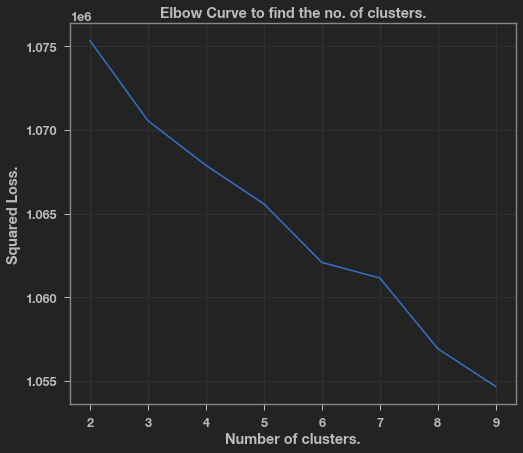

In [70]:
#Elbow Method
def elbow(words_vector):
    num_cluster = [x for x in range(2,10)]
    
    squared_errors = []
    for cluster in num_cluster:
        kmeans = KMeans(n_clusters = cluster).fit(words_vector) # Train Cluster
        squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
        
    optimal_clusters = np.argmin(squared_errors)# As argmin return the index of minimum loss. 
    plt.plot(num_cluster, squared_errors)
    plt.title("Elbow Curve to find the no. of clusters.")
    plt.xlabel("Number of clusters.")
    plt.ylabel("Squared Loss.")
    plt.grid(True)
    plt.show()
    return optimal_clusters

optimal_clusters_elbow = elbow(X)

As you can see there are bends of the curve at 2,5,6 and 7. Since there is an evident bending at 6, we will choose 6 as the optimal clusters. If the range was increased into 2-20 we could get a more suitable optimal cluster point. But since it can lead to memory errors, we have selected the cluster in 2-9 range.

## K-Means

Function that runs the K-Means algorithm `max_k` times and returns a dictionary of each k result.

In [11]:
# Define the k-means clustering function which will call sklearn's KMeans function
def k_means(feature_matrix, num_clusters):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

In [12]:
def get_cluster_data(clustering_obj, tweet_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # Get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # Get key features for each cluster
    # Get news articles belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        article = tweet_data[tweet_data['Cluster'] == cluster_num]['cleanedLinks'].values.tolist()
        cluster_details[cluster_num]['cleanedLinks'] = article
    
    return cluster_details

In [13]:
def print_cluster_data(cluster_data):
    # Print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print('Cluster {} details:'.format(cluster_num))
        print('-'*20)
        print('Key features:', cluster_details['key_features'])
        #print('Tweets in this cluster:')
        #print(', '.join(cluster_details['cleanedLinks'][-10:]))
        plt.figure(figsize=(10,10))
        sentences_as_one_string=' '.join(cluster_details['cleanedLinks'][-10:])
        plt.imshow(WordCloud().generate(sentences_as_one_string))
        
        print('='*40)

Cluster 0 details:
--------------------
Key features: ['nt', 'like', 'night', 'amp', 'day', 'follow', 'new', 'go', 'today', 'see']
Cluster 1 details:
--------------------
Key features: ['harvest', 'food', 'gameinsight', 've', 'ipadgames', 'ipad', 'androidgames', 'iphonegames', 'android', 'iphone']
Cluster 2 details:
--------------------
Key features: ['coin', 'collect', 'gold', 'gameinsight', 've', 'androidgames', 'android', 'ipadgames', 'ipad', 'iphonegames']
Cluster 3 details:
--------------------
Key features: ['fuck', 'nt', 'shit', 'love', 'get', 'like', 'bitch', 'go', 'nigga', 'people']
Cluster 4 details:
--------------------
Key features: ['get', 'nt', 'work', 'love', 'amp', 'do', 'like', 'time', 'back', 'free']
Cluster 5 details:
--------------------
Key features: ['love', 'much', 'follow', 'please', 'nt', 'know', 'happy', 'make', 'birthday', 'one']


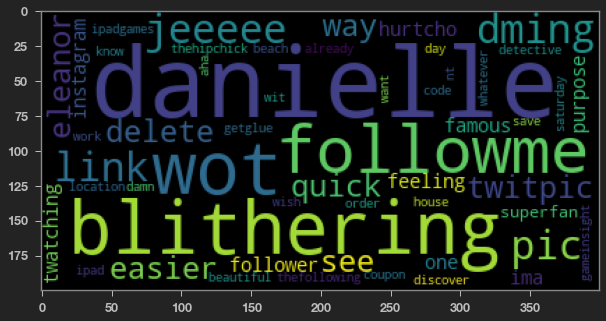

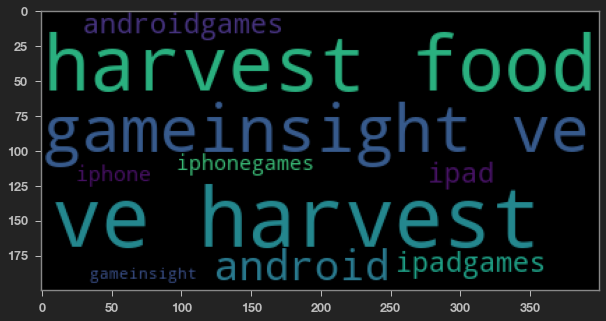

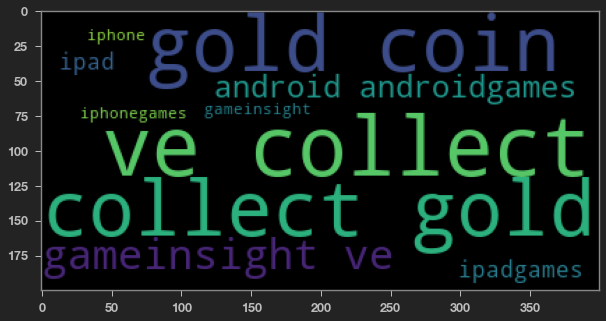

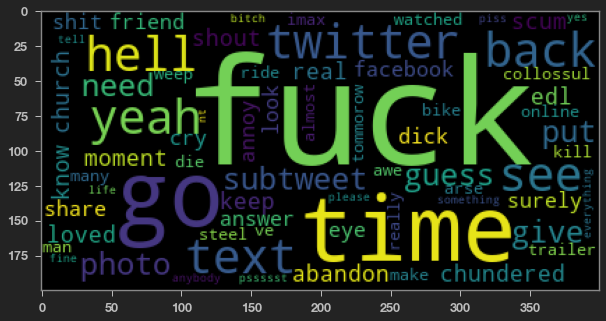

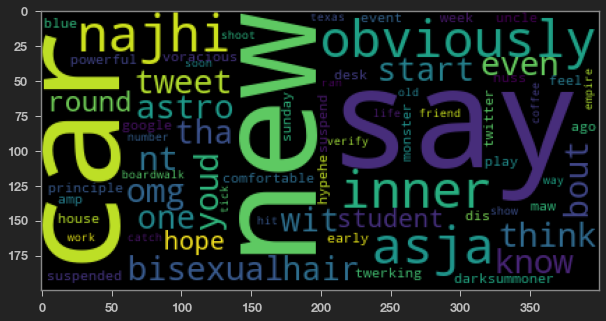

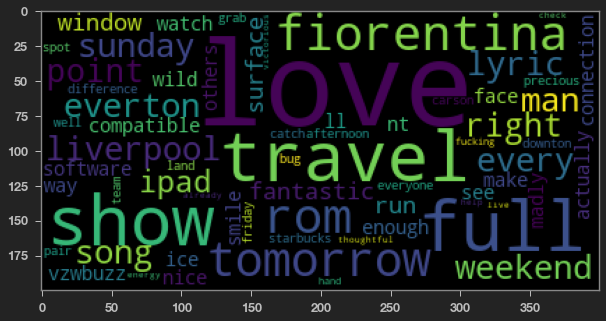

In [92]:
df_tfidf_copy = corpus_copy_df.copy()
feature_names_tfidf = vectorizer.get_feature_names()

num_clusters_tfidf = 6

km_obj_tfidf, clusters_tfidf = k_means(feature_matrix=X,
                           num_clusters=num_clusters_tfidf)

c_tfidf = Counter(clusters_tfidf)

df_tfidf_copy['Cluster'] = clusters_tfidf

# Analyse the k-means clustering data
cluster_data_tfidf =  get_cluster_data(clustering_obj=km_obj_tfidf,
                                 tweet_data=df_tfidf_copy,
                                 feature_names=feature_names_tfidf,
                                 num_clusters=num_clusters_tfidf,
                                 topn_features=10)        

# Print the detailed clustering analysis results
print_cluster_data(cluster_data_tfidf)

### Silhouette Coefficient 

We can use Silhouette Coefficient to find the number of clusters too. It is an another metric to find the optimal number of cluseters.

In [30]:
def silhouetteCoefficient(bag_of_words):
    Y = bag_of_words.copy()
    
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
    
    for n_clusters in range_n_clusters:
    
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(Y)
    
        silhouette_avg = silhouette_score(Y, cluster_labels)
        print("For clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
        

In [ ]:
silhouette_tfidf = silhouetteCoefficient(X) 

Here in silhouette score we take the minimum value to select the number of clusters. Since the minimum values are for 2 and 3 we should omit those since this is not a sentiment analysis. So we will take the number of clusters as 4 and run our code according to that.

### K-Means 

Cluster 0 details:
--------------------
Key features: ['love', 'much', 'follow', 'please', 'nt', 'know', 'happy', 'get', 'make', 'one']
Cluster 1 details:
--------------------
Key features: ['nt', 'get', 'like', 'amp', 'night', 'day', 'go', 'follow', 'today', 'come']
Cluster 2 details:
--------------------
Key features: ['gameinsight', 'island', 'android', 'tribez', 'androidgames', 'complete', 'game', 'quest', 'ipadgames', 'ipad']
Cluster 3 details:
--------------------
Key features: ['gameinsight', 've', 'coin', 'collect', 'gold', 'androidgames', 'android', 'ipadgames', 'ipad', 'harvest']


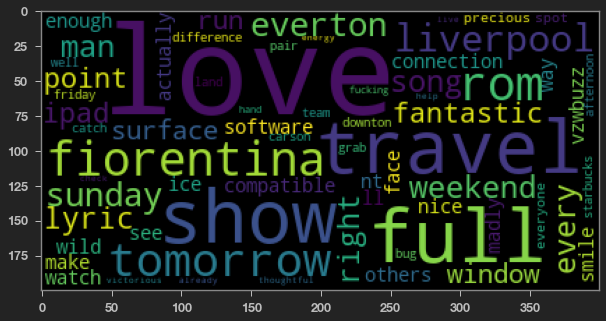

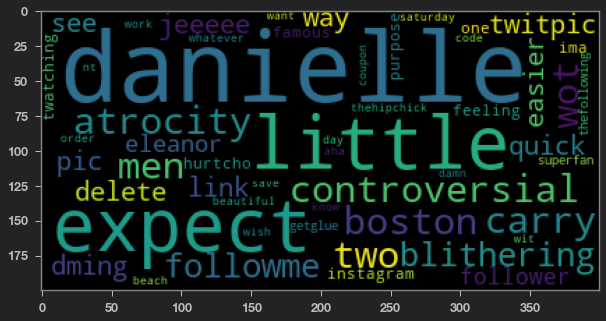

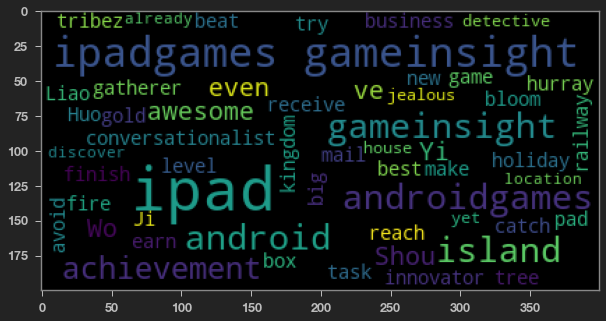

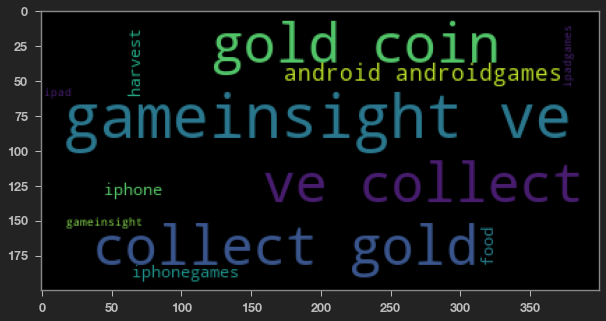

In [14]:
df_tfidf_copy = corpus_copy_df.copy()
feature_names_tfidf = vectorizer.get_feature_names()

num_clusters_tfidf = 4

km_obj_tfidf, clusters_tfidf = k_means(feature_matrix=X,
                           num_clusters=num_clusters_tfidf)

c_tfidf = Counter(clusters_tfidf)

df_tfidf_copy['Cluster'] = clusters_tfidf

# Analyse the k-means clustering data
cluster_data_tfidf =  get_cluster_data(clustering_obj=km_obj_tfidf,
                                 tweet_data=df_tfidf_copy,
                                 feature_names=feature_names_tfidf,
                                 num_clusters=num_clusters_tfidf,
                                 topn_features=10)        

# Print the detailed clustering analysis results
print_cluster_data(cluster_data_tfidf)